In [36]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971, 20006114, 20006007, 20006618
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import numpy as np

# Load dataset
df = pd.read_csv('./dataset.csv')

# Drop unnamed and nulls
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.dropna(inplace=True)

# Convert valence to binary: 0 = sad, 1 = happy
df['valence'] = df['valence'].map(lambda x: 0 if x < 0.5 else 1)

# Convert 'explicit' to int
df['explicit'] = df['explicit'].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True)

# Define target and drop non-feature columns
y = df['valence']
X = df.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'valence', 'duration_ms'])

# Identify numeric features to scale
numeric_features = ['popularity', 'loudness', 'tempo']

# All other features (binary or one-hot) are left as-is
non_scaled_features = [col for col in X.columns if col not in numeric_features]

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('pass', 'passthrough', non_scaled_features)
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
X_processed = pd.DataFrame(X_processed, columns=numeric_features + non_scaled_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)
X_processed

,popularity,loudness,tempo,explicit,danceability,energy,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,0.73,0.791392,0.361245,0,0.676,0.461,0,0.143,0.0322,0.000001,...,False,False,False,False,False,False,False,False,False,False
1,0.55,0.597377,0.318397,0,0.42,0.166,1,0.0763,0.924,0.000006,...,False,False,False,False,False,False,False,False,False,False
2,0.57,0.736123,0.313643,0,0.438,0.359,1,0.0557,0.21,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.71,0.573701,0.746758,0,0.266,0.0596,1,0.0363,0.905,0.000071,...,False,False,False,False,False,False,False,False,False,False
4,0.82,0.737103,0.492863,0,0.618,0.443,1,0.0526,0.469,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113994,0.21,0.612952,0.517705,0,0.172,0.235,1,0.0422,0.64,0.928,...,False,False,False,False,False,False,False,False,False,True
113995,0.22,0.577345,0.350242,0,0.174,0.117,0,0.0401,0.994,0.976,...,False,False,False,False,False,False,False,False,False,True
113996,0.22,0.714648,0.543933,0,0.629,0.329,0,0.042,0.867,0.0,...,False,False,False,False,False,False,False,False,False,True
113997,0.41,0.714759,0.558651,0,0.587,0.506,1,0.0297,0.381,0.0,...,False,False,False,False,False,False,False,False,False,True


In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

# Model 7: ANN
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='tanh',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.002,
    alpha=0.01,
    early_stopping=False,
    max_iter=1,  # One iteration at a time
    warm_start=True,  # Keep weights between fits
    random_state=42
)


n_epochs = 100
patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

train_losses = []
val_losses = []

mlp.partial_fit(X_subtrain, y_subtrain, classes=np.unique(y_train))

for epoch in range(n_epochs):
    mlp.partial_fit(X_subtrain, y_subtrain)

    # Compute log loss on both training and validation sets
    y_subtrain_proba = mlp.predict_proba(X_subtrain)
    y_val_proba = mlp.predict_proba(X_val)

    train_loss = log_loss(y_subtrain, y_subtrain_proba)
    val_loss = log_loss(y_val, y_val_proba)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: \n{accuracy * 100:.2f}%\n")

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Early stopping at epoch 62
Accuracy: 
78.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     18571
           1       0.76      0.77      0.76     15629

    accuracy                           0.78     34200
   macro avg       0.78      0.78      0.78     34200
weighted avg       0.78      0.78      0.78     34200

Confusion Matrix:
[[14757  3814]
 [ 3621 12008]]


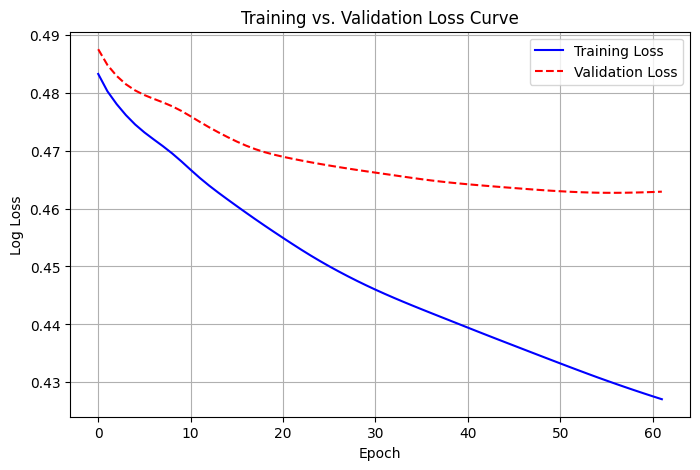

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Training vs. Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

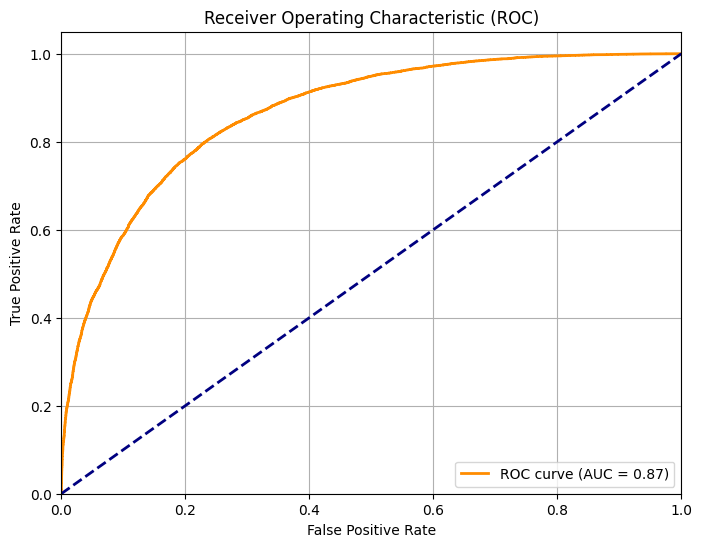

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_scores = mlp.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


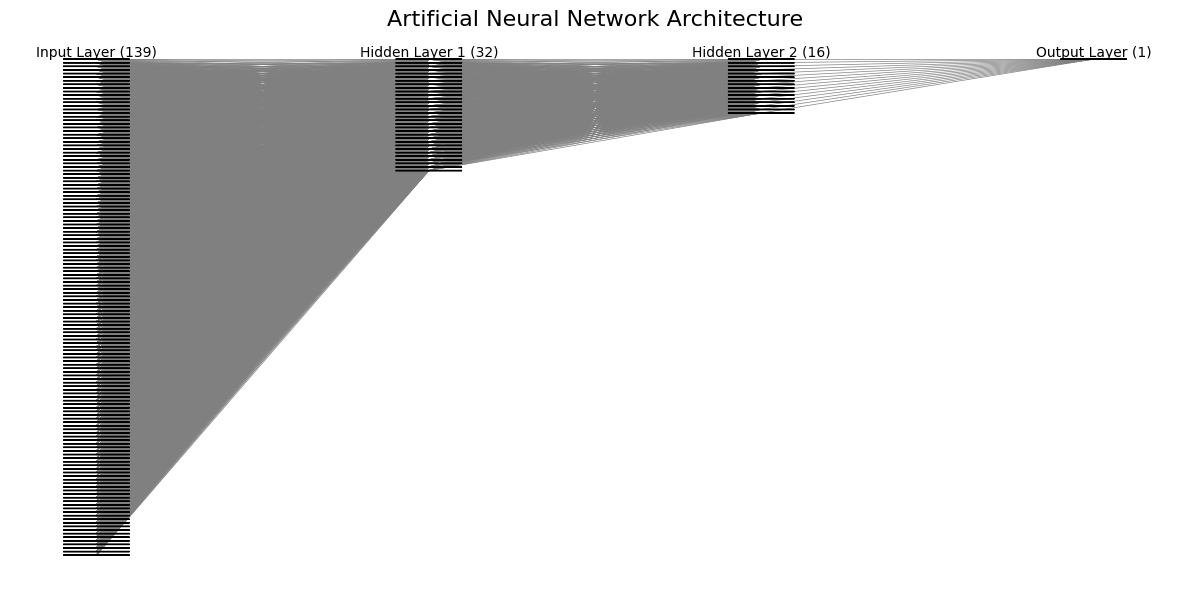

In [44]:
import matplotlib.pyplot as plt

def draw_ann(layer_sizes, node_radius=0.2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    ax.set_title("Artificial Neural Network Architecture", fontsize=16)

    n_layers = len(layer_sizes)
    h_spacing = 2
    max_nodes = max(layer_sizes)
    v_scale = 1.5 if max_nodes < 10 else max_nodes / 5

    positions = {}

    for i, n_nodes in enumerate(layer_sizes):
        layer_x = i * h_spacing
        top_y = (max_nodes - 1) * v_scale / 2
        positions[i] = []

        # Determine layer type and color
        if i == 0:
            color = 'lightgreen'
            label = f"Input Layer ({n_nodes})"
        elif i == n_layers - 1:
            color = 'salmon'
            label = f"Output Layer ({n_nodes})"
        else:
            color = 'skyblue'
            label = f"Hidden Layer {i} ({n_nodes})"

        for j in range(n_nodes):
            y = top_y - j * v_scale
            circle = plt.Circle((layer_x, y), radius=node_radius, fill=True, color=color, ec='black', zorder=3)
            ax.add_patch(circle)
            positions[i].append((layer_x, y))

        # Add label (only once per layer, above top node)
        ax.text(layer_x, top_y + v_scale * 0.7, label, fontsize=10, ha='center')

    # Draw connections
    for i in range(n_layers - 1):
        for (x1, y1) in positions[i]:
            for (x2, y2) in positions[i + 1]:
                ax.plot([x1, x2], [y1, y2], 'gray', linewidth=0.5, zorder=1)

    plt.tight_layout()
    plt.show()

input_size = X_train.shape[1]
output_size = 1  # Binary classification

draw_ann([input_size, 32, 16, output_size])

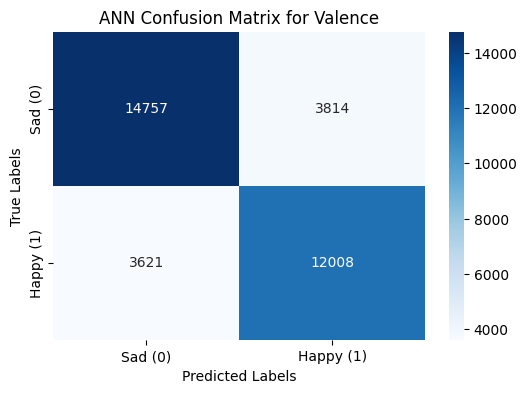

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("ANN Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()